##  Preprocessing of raw images 
 
We chose natural images from the __Hateren Schaaf database__ originally used [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1688904/)

We selected a subset of 137 images that did not contain any human created forms and were not blurred. They were originally preselected in this [paper](https://pubmed.ncbi.nlm.nih.gov/16782164/)

Here we perform preprocessing of the images that then will be fed to the generative algorithms. The images are blocked averaged, scaled and shifted and then passed through a Gaussian filter which aims to emulate retinal ganglion cells. 

After following the directions below on where and how to download the images, you run sequentially all the cells below to process and store the data so that the produced image patches can be used by the generative algorithms.

#### Download the __Hateren Schaaf database__ images

From the website http://bethgelab.org/datasets/vanhateren/ download the *.IMC files, unzip and store them in the directory __sparseRegularizers/databaseHaterenSchaaf/vanhateren_imc/__



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import array
import os


import utils
from generativeModels import SparseModel, runModelSim



### Functions

In [2]:
def getImages(filenamesSelect,baseAddress):

    height = 1024; width = 1536
    imgAll = np.zeros((height,width,len(filenamesSelect)))
    for ind,filename in enumerate(filenamesSelect):
    
        fileLoc = baseAddress+filename
        with open(fileLoc, 'rb') as handle:
           s = handle.read()
        arr = array.array('H', s)
        arr.byteswap()
        imgAll[:,:,ind] = np.array(arr, dtype='float').reshape(height, width)

    return imgAll

In [3]:
#we select the min and the max to rescale from each separate image (instead of taking the max and min of all)
#the pixels become from zero to one
#then we take the mean of the pixels of each image and subtract each pixel of the image with that value
#the mean of the pixels for each image become zero
def rescaleMeanCenterImgs(blockImgAll):

    maxVals = np.max(np.reshape(blockImgAll,(blockImgAll.shape[0]*blockImgAll.shape[1],-1)),axis=0)
    minVals = np.min(np.reshape(blockImgAll,(blockImgAll.shape[0]*blockImgAll.shape[1],-1)),axis=0)
    
    normImgAll = (blockImgAll-minVals)/(maxVals-minVals)

    meanVals = np.mean(np.reshape(normImgAll,(normImgAll.shape[0]*normImgAll.shape[1],-1)),axis=0)
    stdVals = np.std(np.reshape(normImgAll,(normImgAll.shape[0]*normImgAll.shape[1],-1)),axis=0)
    imgAllScaleShift = (normImgAll - meanVals)/stdVals
    
    return imgAllScaleShift

In [4]:
#whitens the images M images of heightXwidth blockImgAll[height,width,M] with a difference of Gaussian filter
#representing the response properties of retinal ganglion cells. Subsequently normalize the images so that they
#all have the same variance (0.1).
def whitenDoG(blockImgAll):

    height,width,M = blockImgAll.shape
    print(f'There are {M} images, each of height {height} and width {width}')
    heightHalf = int(height/2); widthHalf = int(width/2)
    print(f'half of the height is {heightHalf} and half of the width is {widthHalf}')
    heightInd = np.arange(-heightHalf,heightHalf)
    widthInd = np.arange(-widthHalf,widthHalf)
    fx,fy = np.meshgrid(heightInd,widthInd, indexing='ij')
    rho = np.sqrt(fx*fx + fy*fy)
    f0 = 0.4*height
    exponent = -(rho/f0)**4
    filt = rho*np.exp(exponent)

    imgAllFilt = np.zeros_like(blockImgAll)
    for i in np.arange(M):
        imF = np.fft.fft2(blockImgAll[:,:,i])    
        imgAllFilt[:,:,i] = np.fft.ifft2(imF*np.fft.fftshift(filt)).real

    normFactor = np.sqrt(np.mean((np.std(np.reshape(imgAllFilt,(imgAllFilt.shape[0]*imgAllFilt.shape[1],-1)),axis=0)**2)))
    var = np.sqrt(0.1)
    imgAllFiltNorm = var*imgAllFilt/normFactor

    return imgAllFiltNorm


In [5]:
#createRandomCropImagesAndRs gets randomly selected cropped image patches 
#the sequences can be replicated and used for comparisons since we use a random seed
#numCrImages is the same as numRs and it is numIter*batch_size
#sz: size of cropped image szXsz   
#numImages: number of images from where we take the cropped images
#imgs: the images from where we take the cropped images

def createRandomCropImages(numCrImages,sz,imgs, seed = 0):


    np.random.seed(seed)
    H,W,numImages = imgs.shape
    
    #GET THE IMAGES FIRST
    #where to start the upper left corner of the cropped image
    beginx = np.random.randint(0, W-sz, numCrImages)
    beginy = np.random.randint(0, H-sz, numCrImages)
    #from which image to crop
    indImgs = np.random.randint(0, numImages,numCrImages)
    inputs_list = []

    # Get cropped images, normalize them, and store them in inputs_list
    for i in range(numCrImages):        
        img = imgs[:, :, indImgs[i]]
        clop = img[beginy[i]:beginy[i]+sz, beginx[i]:beginx[i]+sz].flatten()
        inputs_list.append(clop - np.mean(clop))

    inputsAll = np.array(inputs_list)

    return inputsAll

#### Get the images with the indeces below preprocess them, get the input image patches and save them

In [6]:

#indeces of the 137 preselected images
imagesNum = ['0061','0094','0199','0225','0353','0369','0388','0472','0477','0538','0619','0699','0764','0791','0827','0887'
,'0960','1024','1041','1067','1102','1116','1142','1150','1186','1204','1274','1288','1377','1385','1692','1723'
,'1749','1778','1829','1848','1867','1875','1893','1899','1902','1966','1993','1996','2066','2098','2118','2131'
,'2162','2198','2205','2261','2280','2294','2310','2341','2350','2369','2397','2405','2473','2508','2511','2516'
,'2535','2537','2562','2569','2573','2597','2615','2637','2671','2715','2796','2822','2895','2996','3004','3014'
,'3038','3053','3104','3116','3178','3181','3198','3224','3240','3251','3268','3305','3335','3362','3371','3388'
,'3420','3421','3432','3437','3451','3491','3509','3527','3532','3587','3613','3660','3664','3671','3741','3748'
,'3762','3802','3808','3831','3835','3848','3896','3929','3969','3998','4000','4027','4029','4049','4053','4080'
,'4089','4101','4103','4115','4153','4180','4184','4202','4204']

filenamesSelect = []
for part in imagesNum:
    whole = 'imk0'+part+'.imc'
    filenamesSelect.append(whole)


baseAddress = 'databaseHaterenSchaaf/vanhateren_imc/'

#Get original images
imgAll = getImages(filenamesSelect,baseAddress)
fileSaveRaw = 'data/imagesField.pckl'
utils.saveVar((filenamesSelect,imgAll),fileSaveRaw)

#rescale its image to be between zero and one
preproImgAll = rescaleMeanCenterImgs(imgAll)

#whiten the images as in:  
#Olshausen BA, Field DJ (1997)  Sparse Coding with an Overcomplete  Basis Set: A Strategy Employed by V1?  Vision Research, 37: 3311-3325.
imgAllFiltNorm = whitenDoG(preproImgAll)
fileSave = 'data/DoGImagesScaleShift.pckl'
utils.saveVar(imgAllFiltNorm,fileSave)


numIter = 4000 ;batchSize = 250
numCrImages = numIter*batchSize
sz = 16 #size of one side of the square patch
seed = 0
print(f'The algorithm iterates a batch of {batchSize} cropped images of size {sz}X{sz} {numIter} times')
print(f'So in total we use {numCrImages} patches')

#Get the cropped imagess that we are going to use for all algorithms
inputsAll = createRandomCropImages(numCrImages,sz,imgAllFiltNorm, seed)
print(f'the number of patches is {inputsAll.shape[0]}(0 dimension) and the size of each patch is {inputsAll.shape[1]}(1 dimension)')

fileSave = 'data/DoGPatchesScaleShift.pckl'
utils.saveVar(inputsAll,fileSave)








There are 137 images, each of height 1024 and width 1536
half of the height is 512 and half of the width is 768
The algorithm iterates a batch of 250 cropped images of size 16X16 4000 times
So in total we use 1000000 patches
the number of patches is 1000000(0 dimension) and the size of each patch is 256(1 dimension)


### Load and show examples of raw and whitened images

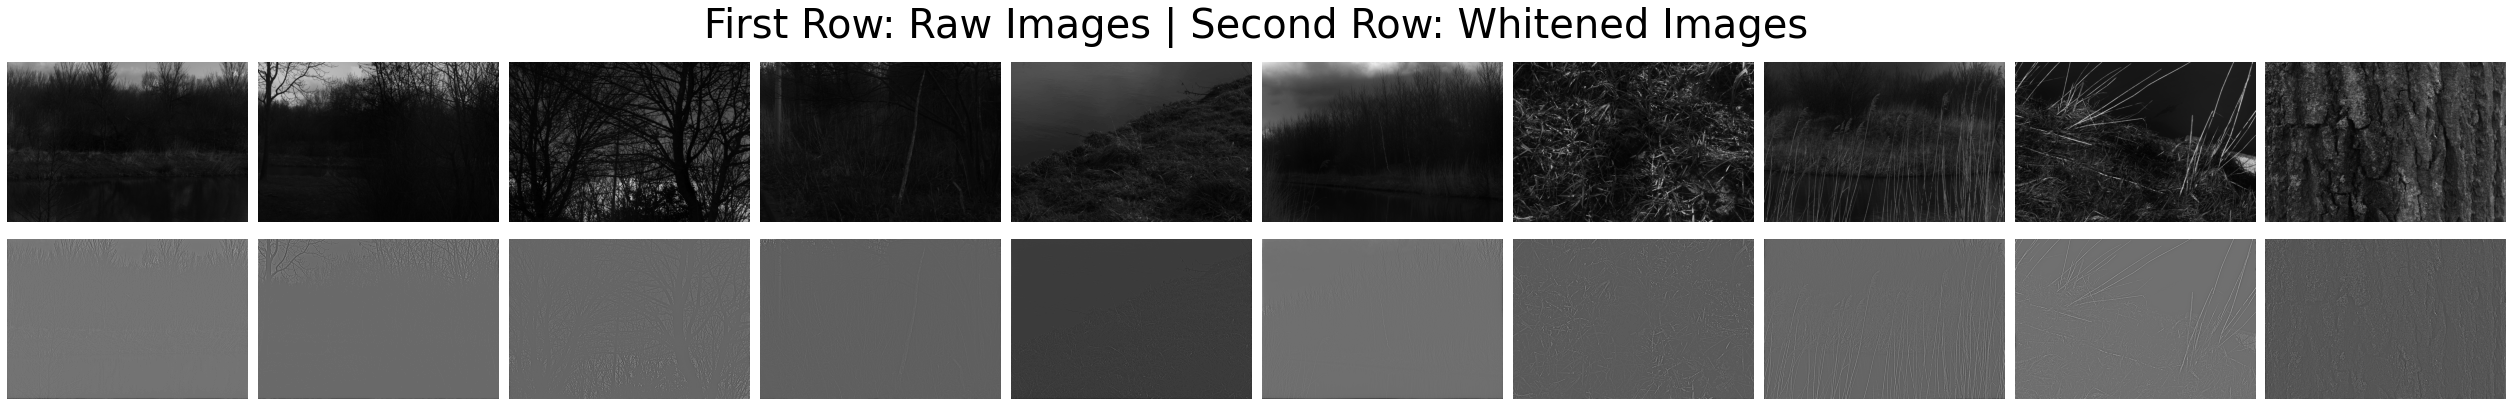

In [7]:
#Load raw and whitened images
fileLoad = 'data/imagesField.pckl'
(filenamesSelect,imgsRaw) = utils.loadVar(fileLoad)

fileLoad = 'data/DoGImagesScaleShift.pckl'
imgsWhitened = utils.loadVar(fileLoad)

# Plot datasets
fig = plt.figure(figsize=(35, 6))
numImages = 10
for i in range(numImages):
    plt.subplot(2, numImages, i+1)
    plt.imshow(imgsRaw[:,:,i], cmap="gray")
    plt.axis("off")

for i in range(numImages):
    plt.subplot(2, numImages, i+numImages+1)
    plt.imshow(imgsWhitened[:,:,i], cmap="gray")
    plt.axis("off")
    
    
plt.tight_layout()
fig.suptitle("First Row: Raw Images | Second Row: Whitened Images", fontsize=40)
plt.subplots_adjust(top=0.9) 
 